In [1]:
import RNA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import SVG, display

from collections import Counter
from collections import defaultdict
import subprocess
import difflib
import sys
import os
import random
import string
import time

import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append('../')
from pretty_print_path import print_moves
import findpath_librna
import findpath


In [2]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True) # no scientific notation

# import feature_generation
from features import ij_distance, new_move_dist, plt_moves, config_distance, balance_in_all_things, return_shift_moves
from process_features import fp_call, find_moves, process

## tf part

In [3]:
input_file = "move_diversity.csv"

dataframe = pd.read_csv(input_file, index_col=0)
# dataframe['target'] = np.where(dataframe["3"]==1, 1, 0)
dataframe = dataframe.drop(labels="s", axis=1)
dataframe = dataframe.drop(labels="sequence", axis=1)
dataframe = dataframe.drop(labels="s2", axis=1)
dataframe = dataframe.drop(labels="i", axis=1)
# dataframe = dataframe.drop(labels="j", axis=1)
# dataframe = dataframe.drop(labels="found", axis=1)

dataframe

,j,target,en_mean,en_std,best_en
0,0.001667,0.166667,0.705833,0.077078,0.540
1,0.000000,0.000000,0.595000,0.126254,0.345
2,0.000000,0.000000,0.683611,0.102508,0.445
3,0.000000,0.000000,0.690588,0.079073,0.545
4,0.002000,0.200000,0.678000,0.032802,0.625
...,...,...,...,...,...
1528,0.000000,0.000000,0.656429,0.096943,0.430
1529,0.000000,0.000000,0.650833,0.096821,0.470
1530,0.000000,0.000000,0.680000,0.124479,0.415
1531,0.000000,0.000000,0.700000,0.077881,0.600


In [24]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

# list(train["target"])
# list(train["j"])

102 train examples
26 validation examples
33 test examples


In [91]:
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

X.shape, y.shape

((40, 1), (40,))

In [92]:
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

X = np.array([test["j"]]).T
y = np.array(test["target"])

X,y
X.shape, y.shape


((33, 1), (33,))

## feature selection

## tf regression

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


input_file = "move_diversity.csv"
input_file = "move_diversity4.csv"
dataframe = pd.read_csv(input_file, index_col=0)
# dataframe['target'] = np.where(dataframe["3"]==1, 1, 0)
dataframe = dataframe.drop(labels="s", axis=1)
dataframe = dataframe.drop(labels="sequence", axis=1)
dataframe = dataframe.drop(labels="s2", axis=1)
dataframe = dataframe.drop(labels="i", axis=1)
dataframe = dataframe.drop(labels="j", axis=1)


dataframe = dataframe.drop(labels="foundpos", axis=1)
dataframe = dataframe.drop(labels="foundpos_abs", axis=1)
dataframe = dataframe.drop(labels="distlast", axis=1)
dataframe = dataframe.drop(labels="unique_labels", axis=1)

# dataframe = dataframe.drop(labels="vic", axis=1)
# dataframe = dataframe.drop(labels="vic_best", axis=1)
# dataframe = dataframe.drop(labels="unique_moves", axis=1)
# dataframe = dataframe.drop(labels="distlast", axis=1)

# dataframe = dataframe.drop(labels="found", axis=1)

dataframe

,target,en_mean,en_std,best_en
0,0.166667,0.685833,0.076726,0.6050
1,0.000000,0.692000,0.135945,0.4300
2,0.000000,0.599000,0.180538,0.3600
3,0.777778,0.694722,0.083074,0.5400
4,0.000000,0.618900,0.110494,0.4445
...,...,...,...,...
1065,0.066667,0.715000,0.062477,0.5550
1066,0.000000,0.653750,0.114639,0.4250
1067,0.062500,0.640625,0.060205,0.5350
1068,0.000000,0.626667,0.086538,0.4400


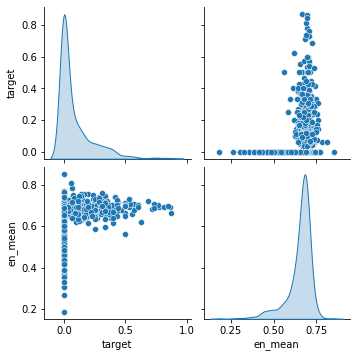

In [43]:
# sns.pairplot(dataframe[['target', 'best_en']], diag_kind='kde')
sns.pairplot(dataframe[['target', 'en_mean']], diag_kind='kde')

In [44]:
train_dataset = dataframe.sample(frac=0.8, random_state=0)
test_dataset = dataframe.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')

train_features

# train_dataset.describe().transpose()[['mean', 'std']]



,en_mean,en_std,best_en
928,0.691053,0.090008,0.520
780,0.688083,0.042391,0.600
564,0.696522,0.092776,0.525
520,0.641111,0.118387,0.375
399,0.683167,0.083790,0.505
...,...,...,...
1009,0.700478,0.097975,0.510
207,0.674286,0.092309,0.415
438,0.688077,0.057963,0.535
552,0.666250,0.060091,0.585


In [45]:
# horsepower = np.array(train_features['en_mean'])

# horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
# horsepower_normalizer.adapt(horsepower)

# horsepower_model = tf.keras.Sequential([
#     horsepower_normalizer,
#     layers.Dense(units=1)
# ])

# horsepower_model.summary()
# horsepower_model.predict(horsepower[:10])

# horsepower_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss='mean_absolute_error')

# history = horsepower_model.fit(
# train_features['en_mean'],
# train_labels,
# epochs=100,
# # Suppress logging.
# verbose=1,
# # Calculate validation results on 20% of the training data.
# validation_split = 0.2)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

# # history
# plot_loss(history)

In [10]:
# test_results = {}

# test_results['horsepower_model'] = horsepower_model.evaluate(
#     test_features['en_mean'],
#     test_labels, verbose=0)

# x = tf.linspace(0.0, 1, 2)
# y = horsepower_model.predict(x)

# def plot_horsepower(x, y):
#   plt.scatter(train_features['en_mean'], train_labels, label='Data')
#   plt.plot(x, y, color='k', label='Predictions')
#   plt.xlabel('en_mean')
#   plt.ylabel('MPG')
#   plt.legend()


# plot_horsepower(x,y)

## linear regression with multiple inputs

In [219]:
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(np.array(train_features))

# linear_model = tf.keras.Sequential([
#     normalizer,
#     layers.Dense(units=1)
# ])

# # linear_model.predict(train_features[:10])
# # linear_model.layers[1].kernel

# linear_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss='mean_absolute_error')

# history = linear_model.fit(
#     train_features,
#     train_labels,
#     epochs=100,
#     # Suppress logging.
#     # verbose=0,
#     # Calculate validation results on 20% of the training data.
#     validation_split = 0.2)

# plot_loss(history)

In [220]:
# linear_model.evaluate(
#     test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_15 (Dense)            (None, 50)                200       
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2,808
Trainable params: 2,801
Non-trainable params: 7
____________________________________________________

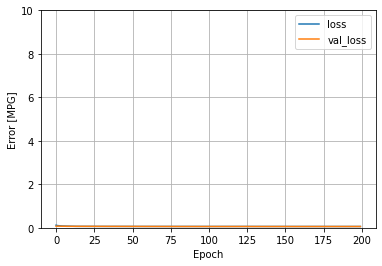

In [47]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      # layers.Dense(128, activation='relu'),
      # layers.Dense(128, activation='relu'),
      layers.Dense(50, activation='relu'),
      layers.Dense(50, activation='relu'),
      layers.Dropout(.2),
      # layers.Dropout(.5),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=200)

plot_loss(history)

In [48]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

0.082610584795475

In [49]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

data = {'en_mean': [0.678000],
        'en_std': 0.0328022,
        'best_en': 0.625,
        'vic': 0,
        'vic_best': 0,
        'unique_moves': 1,
        'distlast': 0.130}

test_features2 = pd.DataFrame.from_dict(data)
test_features2

,en_mean,en_std,best_en,vic,vic_best,unique_moves,distlast
0,0.678,0.032802,0.625,0,0,1,0.13


## Predictions

INFO:tensorflow:Assets written to: dnn_model4/assets


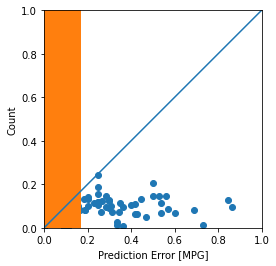

In [50]:
dnn_model.save('dnn_model4')

test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [51]:
test_predictions = dnn_model.predict(test_features).flatten()

stacked = np.stack([test_labels, test_predictions], axis=1)
df_testoutput = pd.DataFrame(stacked, columns=["labels", "prediction"])
df_testoutput.to_csv("dataset_results2.csv")

df_testoutput

,labels,prediction
0,0.000000,0.000550
1,0.142857,0.060292
2,0.000000,0.000550
3,0.346154,0.073492
4,0.000000,0.000550
...,...,...
209,0.300000,0.129299
210,0.600000,0.068353
211,0.000000,0.075453
212,0.066667,0.163940
